In [ ]:
!python -m spacy download en_core_web_lg

In [3]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_lg
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
training_data = pd.read_csv('/content/twitter_training.csv', header=None)
training_data.head(10)

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [5]:
training_data.drop([0,1], axis=1, inplace=True)
training_data.columns = ['sentiment', 'text']
training_data.tail(5)

,sentiment,text
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...
74681,Positive,Just like the windows partition of my Mac is l...


In [6]:
training_data["sentiment"] = np.where(training_data["sentiment"] == "Positive", 1, 0)

<Axes: xlabel='sentiment', ylabel='count'>

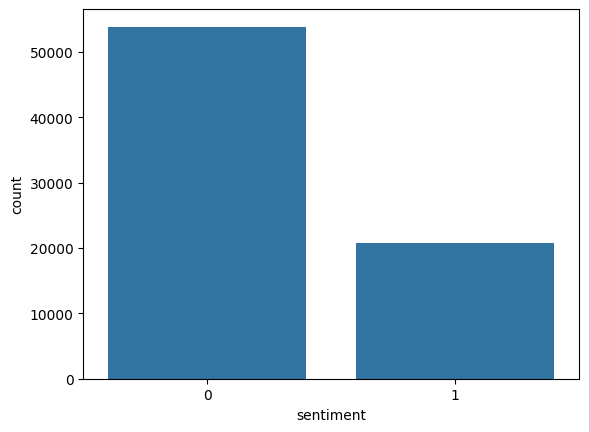

In [7]:
sns.countplot(training_data, x='sentiment')

In [8]:
training_data['sentiment'].unique()

array([1, 0])

In [9]:
training_data['sentiment'].value_counts()

,count
sentiment,
0,53850
1,20832


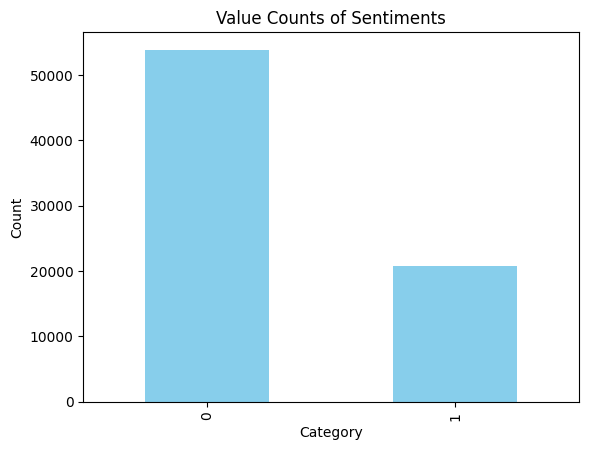

In [10]:
counts = training_data['sentiment'].value_counts()

counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Value Counts of Sentiments')
plt.show()

In [11]:
stop_words = STOP_WORDS

In [12]:
nlp = en_core_web_lg.load()
nlp

In [19]:
def preprocessamento(texto):
  texto = texto.lower()

   # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r" +", ' ', texto)



  documento = nlp(texto)

  lista = []
  for token in documento:
    lista.append(token.lemma_)


  lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])

  return lista

In [20]:
training_data['text'] = training_data['text'].astype(str)

In [21]:
training_data['text'] = training_data['text'].apply(preprocessamento)
training_data.head(10)

,sentiment,text
0,1,I m borderland I murder
1,1,I come border I kill
2,1,I m borderland I kill
3,1,I m come borderland I murder
4,1,I m borderland I murder I
5,1,I m borderland I murder
6,1,I spend hour fun know I huge fan maya favorite...
7,1,I spend couple hour fun ... know I huge border...
8,1,I spend hour fun ... know I huge borderland fa...
9,1,I spend hour fun know I huge rhandlerr fan may...


In [22]:
max_features = 10000

word_tokenizer = Tokenizer(
    oov_token="<OOV>",
    lower=True,
    num_words=max_features,
)

In [23]:
word_tokenizer.fit_on_texts(training_data["text"])

In [24]:
x_sequences = word_tokenizer.texts_to_sequences(training_data["text"])

In [25]:
x_padded = pad_sequences(x_sequences, padding="post", truncating="post", maxlen=100)

In [26]:
x_train, y_train = x_padded, training_data['sentiment']

x_train.shape, y_train.shape

((74682, 100), (74682,))

In [27]:
val_data = pd.read_csv("twitter_validation.csv", header=None)
val_data.head(10)

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
5,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
6,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
7,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
8,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...
9,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...


In [28]:
val_data.drop([0,1], axis=1, inplace=True)
val_data.columns = ['sentiment', 'text']
val_data.head(10)

,sentiment,text
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...
5,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
6,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
7,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
8,Positive,my ass still knee-deep in Assassins Creed Odys...
9,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...


In [29]:
val_data.tail(5)

,sentiment,text
995,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,Positive,Today sucked so it’s time to drink wine n play...
998,Positive,Bought a fraction of Microsoft today. Small wins.
999,Neutral,Johnson & Johnson to stop selling talc baby po...


In [30]:
val_data["sentiment"] = np.where(val_data["sentiment"] == "Positive", 1, 0)

In [31]:
val_data['text'] = val_data['text'].astype(str)
val_data["text"] = val_data["text"].apply(preprocessamento)

x_val_sequences = word_tokenizer.texts_to_sequences(val_data["text"])
x_val_padded = pad_sequences(x_val_sequences, padding="post", truncating="post", maxlen=100)
y_val = val_data["sentiment"]

In [36]:
max_features = len(word_tokenizer.word_index) + 11
output_dim = 64

In [37]:
model = Sequential([
    Embedding(input_dim=max_features, output_dim=output_dim),
    LSTM(64, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
    ]
)

In [38]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [40]:
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_val_padded, y_val), callbacks=[early_stopping])

Epoch 1/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 168s 71ms/step - accuracy: 0.7301 - loss: 0.5750 - val_accuracy: 0.7230 - val_loss: 0.5111
Epoch 2/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 200s 70ms/step - accuracy: 0.7214 - loss: 0.5174 - val_accuracy: 0.7980 - val_loss: 0.4487
Epoch 3/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 204s 71ms/step - accuracy: 0.7723 - loss: 0.4442 - val_accuracy: 0.8720 - val_loss: 0.3132
Epoch 4/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 199s 69ms/step - accuracy: 0.8385 - loss: 0.3466 - val_accuracy: 0.8320 - val_loss: 0.4138
Epoch 5/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 201s 69ms/step - accuracy: 0.8392 - loss: 0.3307 - val_accuracy: 0.9140 - val_loss: 0.2236
Epoch 6/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 202s 69ms/step - accuracy: 0.8896 - loss: 0.2496 - val_accuracy: 0.9420 - val_loss: 0.1738
Epoch 7/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 205s 71ms/step - accuracy: 0.9143 - loss: 0.2031 - val_accuracy: 0.9450 - val_loss: 0.1520
Epoch 8/40
2334/2334 ━━━━━━━━━━━━━━━━━━━━ 161s 69ms/step - accuracy: 

In [51]:
loss, acc = model.evaluate(x_val_padded, y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9706 - loss: 0.1482


In [52]:
print(f"Model Loss: {loss}\nModel Accuracy: {acc}")

Model Loss: 0.11011572182178497
Model Accuracy: 0.9760000109672546


In [53]:
history_dict = history.history

In [54]:
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

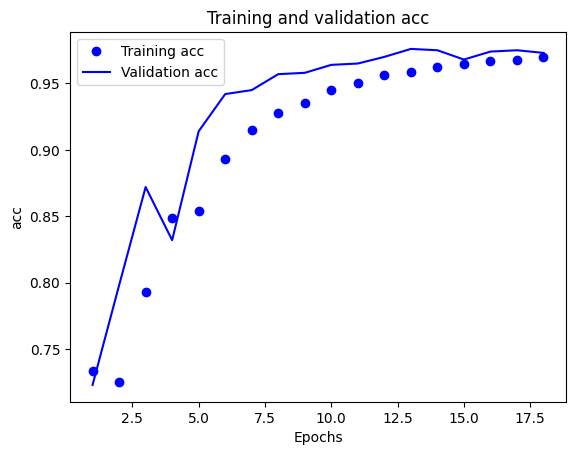

In [55]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training acc')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

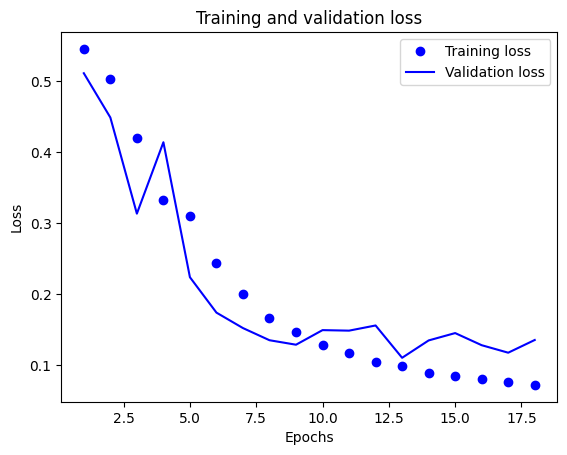

In [56]:
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()